In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from mlresearch.utils import set_matplotlib_style
from recgame.environments import BaseEnvironment
from recgame.recourse import DiCE
from recgame.utils import generate_synthetic_data

In [9]:
set_matplotlib_style(16)

# Some variables to define the problem
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)
N_CONTINUOUS = 2
N_CAT = 0
N_AGENTS = 100

# Environment variables
N_LOANS = 10  # np.array([20, 1, 10, 30, 0, 5, 50, 10, 40])
ADAPTATION = .3  # np.array([.2, .1, .3, .25, .1, .4, .05, .05, .2])
NEW_AGENTS = 10  # np.array([40, 10, 50, 5, 0, 100, 0, 0, 20])

df, y, categorical = generate_synthetic_data(N_AGENTS, N_CONTINUOUS, N_CAT, RNG_SEED)

model = RandomForestClassifier().fit(df, y)
# model = LogisticRegression().fit(df, y)

In [10]:
def data_source_func(n_agents):
    X, _, _ = generate_synthetic_data(
        n_agents=n_agents,
        n_continuous=N_CONTINUOUS,
        n_categorical=N_CAT,
        random_state=rng,
    )
    return X

# TESTS

In [11]:
X = df[model.predict(df) == 0].copy()


import dice_ml
from sklearn.neighbors import NearestNeighbors

d = dice_ml.Data(
    dataframe=pd.concat(
        [X, pd.Series(model.predict(X), name="y")], axis=1
    ),
    continuous_features=X.columns.drop(categorical).tolist(),
    outcome_name="y",
)
m = dice_ml.Model(model, backend="sklearn")
exp = dice_ml.Dice(d, m)

dice_exp = exp.generate_counterfactuals(
    X,
    total_CFs=5,
    desired_class=1,
    random_seed=42
)

 22%|███████████████████                                                                  | 11/49 [00:02<00:07,  4.77it/s]


KeyboardInterrupt: 

In [5]:
dice_exp.cf_examples_list[0].final_cfs_df.drop(columns="y")

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1).fit(dice_exp.cf_examples_list[0].final_cfs_df.drop(columns="y"))

dice_exp.cf_examples_list[0].final_cfs_df.drop(columns="y").iloc[nn.kneighbors(X.iloc[:1])[-1].squeeze()]

model.predict_proba(dice_exp.cf_examples_list[0].final_cfs_df.drop(columns="y"))[:,1]

array([0.92, 0.8 , 0.57, 0.92, 0.52])

In [6]:
model.predict_proba(X.iloc[:1]), model.predict_proba(pd.DataFrame(dice_exp.cf_examples_list[0].final_cfs_df.drop(columns="y").iloc[nn.kneighbors(X.iloc[:1])[-1].squeeze()]).T)

(array([[0.83, 0.17]]), array([[0.43, 0.57]]))

In [7]:
recourse = DiCE(model, threshold=0.6, categorical=categorical, random_state=42)
df_cf = recourse.counterfactual(df)

100%|█████████████████████████████████████████████████████████████████████████████████████| 49/49 [15:17<00:00, 18.73s/it]


In [8]:
model.predict_proba(df_cf)[:,1] > .6

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

# Environment experiment

In [12]:
# Define the necessary components to run simulation
recourse = DiCE(model, categorical=categorical)
recourse.set_actions(df)
recourse.action_set_.ub = [2, 2]

environment = BaseEnvironment(
    X=df,
    recourse=recourse,
    data_source_func=data_source_func,
    threshold=N_LOANS,
    threshold_type="absolute",
    adaptation=ADAPTATION,
    behavior_function="continuous_flexible",
    growth_rate=NEW_AGENTS,
    growth_rate_type="absolute",
    random_state=RNG_SEED,
)

environment.simulate(5)

100%|█████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.37it/s]


BaseEnvironment(X=         f_0       f_1
0   0.601572  0.153339
1   0.750150  0.813522
2  -0.150345  0.065940
3   0.542613  0.394586
4   0.494400  0.215652
..       ...       ...
95  1.074555  0.440160
96  0.372271  0.987148
97  0.130985  0.201758
98  0.714442  0.368465
99  0.498293  0.445519

[100 rows x 2 columns],
                adaptation=0.3,
                data_source_func=<function data_source_func at 0x7f42485e95a0>,
                growth_rate=10, growth_rate_type='absolute', random_state=42,
                recourse=DiCE(categorical=[], model=RandomForestClassifier(),
                              threshold=0.62),
                threshold=10)

<Axes: title={'center': 'Population scores over 5 time steps'}, xlabel='Step', ylabel='Score'>

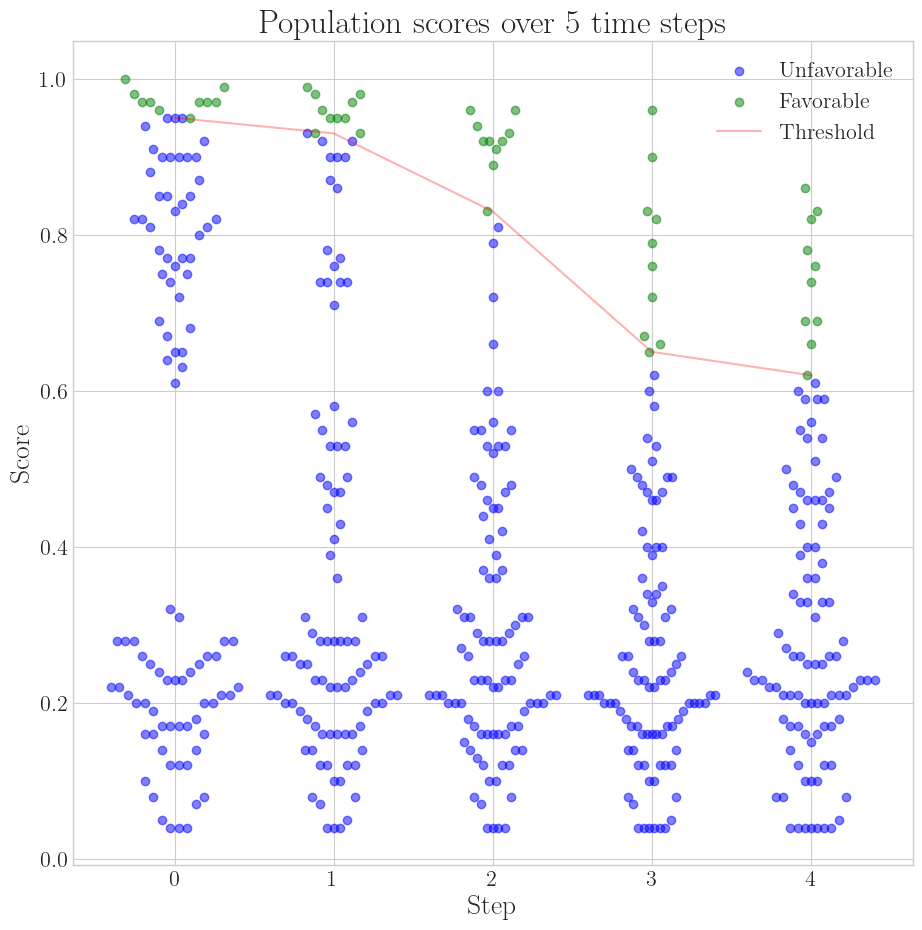

In [13]:
environment.plot.agent_scores()

<Axes: title={'center': 'Population at t=4'}, xlabel='f_0', ylabel='f_1'>

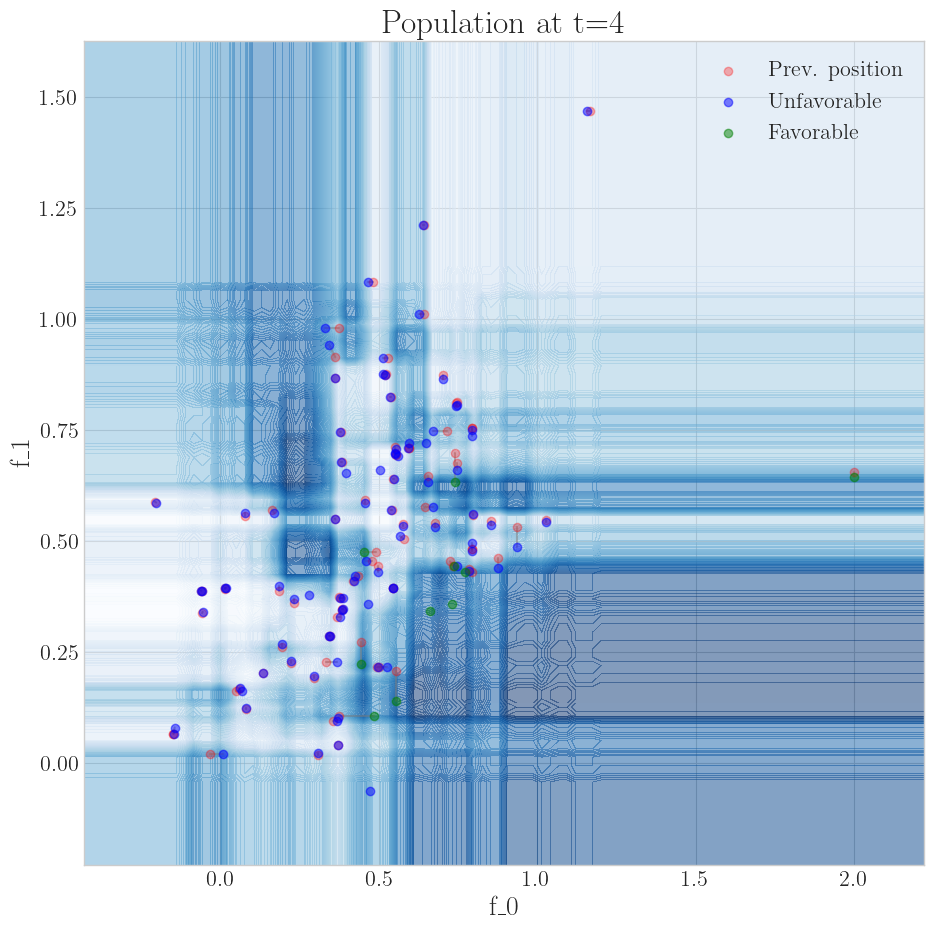

In [14]:
environment.plot.scatter(4)